In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from aif360.datasets import StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.algorithms.preprocessing import Reweighing
# from aif360.algorithms.inprocessing import ExponentiatedGradient
# from aif360.algorithms.inprocessing import DemographicParity
from aif360.metrics import ClassificationMetric
from sklearn.metrics import accuracy_score  
from fairlearn.metrics import demographic_parity_difference, equalized_odds_difference
# Load the dataset

c:\Users\RodahNambuyaChepkori\anaconda3\Lib\site-packages\inFairness\utils\ndcg.py:37: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.vmap` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.vmap` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  vect_normalized_discounted_cumulative_gain = vmap(
c:\Users\RodahNambuyaChepkori\anaconda3\Lib\site-packages\inFairness\utils\ndcg.py:48: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.vmap` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.vmap` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  monte_carlo_vect_nd

In [21]:
df=pd.read_csv("compas-scores-two-years.csv")
df.head()

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7214 entries, 0 to 7213
Data columns (total 53 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       7214 non-null   int64  
 1   name                     7214 non-null   object 
 2   first                    7214 non-null   object 
 3   last                     7214 non-null   object 
 4   compas_screening_date    7214 non-null   object 
 5   sex                      7214 non-null   object 
 6   dob                      7214 non-null   object 
 7   age                      7214 non-null   int64  
 8   age_cat                  7214 non-null   object 
 9   race                     7214 non-null   object 
 10  juv_fel_count            7214 non-null   int64  
 11  decile_score             7214 non-null   int64  
 12  juv_misd_count           7214 non-null   int64  
 13  juv_other_count          7214 non-null   int64  
 14  priors_count            

In [24]:
# drop columns with violent
df=df.drop(columns=['violent_recid',
       'is_violent_recid', 'vr_case_number', 'vr_charge_degree',
       'vr_offense_date', 'vr_charge_desc', 'type_of_assessment',
       'decile_score.1', 'score_text', 'screening_date',
       'v_type_of_assessment', 'v_decile_score', 'v_score_text',
       'v_screening_date', 'in_custody', 'out_custody', 'priors_count.1',
       'start', 'end', 'event','name', 'first', 'last', 'compas_screening_date', 'dob', 'c_jail_in', 'c_jail_out', 'c_case_number', 'c_charge_degree', 'c_charge_desc', 'c_offense_date', 'c_arrest_date'], axis=1)

In [25]:
df.shape

(7214, 21)

In [27]:
df=df.drop(columns=['r_case_number',
       'r_charge_degree', 'r_days_from_arrest', 'r_offense_date',
       'r_charge_desc', 'r_jail_in', 'r_jail_out',
       'days_b_screening_arrest'], axis=1)

# Drop c_days_from_compas if it exists
df = df.drop(columns=['c_days_from_compas'], errors='ignore')

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7214 entries, 0 to 7213
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               7214 non-null   int64 
 1   sex              7214 non-null   object
 2   age              7214 non-null   int64 
 3   age_cat          7214 non-null   object
 4   race             7214 non-null   object
 5   juv_fel_count    7214 non-null   int64 
 6   decile_score     7214 non-null   int64 
 7   juv_misd_count   7214 non-null   int64 
 8   juv_other_count  7214 non-null   int64 
 9   priors_count     7214 non-null   int64 
 10  is_recid         7214 non-null   int64 
 11  two_year_recid   7214 non-null   int64 
dtypes: int64(9), object(3)
memory usage: 676.4+ KB


In [29]:
cat=df.select_dtypes(include=['object']).columns
cat

Index(['sex', 'age_cat', 'race'], dtype='object')

In [37]:
import re

# robust mapping for common race strings -> integer codes
race_mapping = {
    'african-american': 1,
    'african american': 1,
    'asian': 5,
    'caucasian': 2,
    'white': 2,
    'hispanic': 3,
    'native american': 4,
    'native-american': 4,
    'other': 0,
    'unknown': 0
}

def _normalize_race(x):
    if pd.isna(x):
        return x
    s = str(x).strip().lower()
    s = re.sub(r'[^\w\s-]', '', s)        # remove punctuation except hyphen
    s = re.sub(r'\s+', ' ', s)           # collapse whitespace
    return s

# Apply encoding only if race column contains strings (object dtype). If already numeric, this is a no-op.
if df['race'].dtype == 'O' or df['race'].dtype == object:
    df['race'] = df['race'].apply(lambda v: race_mapping.get(_normalize_race(v), v))

# Ensure a label_encoder entry for downstream code (won't overwrite other entries if present)
label_encoder = globals().get('label_encoder', {})
label_encoder.setdefault('race', {'Other': 0,
                                 'African-American': 1,
                                 'Caucasian': 2,
                                 'Hispanic': 3,
                                 'Native American': 4,
                                 'Asian': 5})
# attach back to globals for later cells
globals()['label_encoder'] = label_encoder

print("Race encoding applied. value counts:")
print(df['race'].value_counts())

Race encoding applied. value counts:
race
1    3696
2    2454
3     637
0     377
5      32
4      18
Name: count, dtype: int64


In [30]:
#label encoding
label_encoder = {}
for column in df.select_dtypes(include=['object']).columns:
    label_encoder[column] = {label: idx for idx, label in enumerate(df[column].unique())}
    df[column] = df[column].map(label_encoder[column])
df.head()

,id,sex,age,age_cat,race,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,is_recid,two_year_recid
0,1,0,69,0,0,0,1,0,0,0,0,0
1,3,0,34,1,1,0,3,0,0,0,1,1
2,4,0,24,2,1,0,4,0,1,4,1,1
3,5,0,23,2,1,0,8,1,0,1,0,0
4,6,0,43,1,0,0,1,0,0,2,0,0


In [38]:
#split data
X = df.drop('two_year_recid', axis=1)
y = df['two_year_recid']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)   
print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

Training set shape: (5771, 11)
Testing set shape: (1443, 11)


In [39]:
#fitting the model
model = LogisticRegression()
model.fit(X_train, y_train)
# Predict on the test set
y_pred = model.predict(X_test)
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9757449757449758


c:\Users\RodahNambuyaChepkori\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [40]:
# Create AIF360 dataset for fairness evaluation
dataset_test = StandardDataset(
    pd.concat([X_test, y_test], axis=1),
    label_name='two_year_recid',
    favorable_classes=[1],
    protected_attribute_names=['race'],
    privileged_classes=[[2]]  # Caucasian (encoded as 2)
)

# Add predictions to the dataset
dataset_test.labels = y_pred.reshape(-1, 1)

# Compute fairness metrics
metric = ClassificationMetric(
    dataset_test,
    dataset_test,
    unprivileged_groups=[{'race': 1}],  # African-American
    privileged_groups=[{'race': 2}]      # Caucasian
)

print("=== Fairness Metrics (Race Bias) ===")
print(f"Disparate Impact Ratio: {metric.disparate_impact():.4f}")
print(f"Mean Difference: {metric.mean_difference():.4f}")
print(f"Equal Opportunity Difference: {metric.equal_opportunity_difference():.4f}")
print(f"Theil Index: {metric.theil_index():.4f}")
print(f"\nNote: Values close to 1.0 (disparate impact) or 0.0 (other metrics) indicate fairness")

=== Fairness Metrics (Race Bias) ===
Disparate Impact Ratio: 1.3781
Mean Difference: 0.1460
Equal Opportunity Difference: 0.0000
Theil Index: 0.0000

Note: Values close to 1.0 (disparate impact) or 0.0 (other metrics) indicate fairness


There is some bias indicated by the Disparate Impact Ratio (1.38) and Mean Difference (0.1474), meaning one racial group is favored slightly more.
However, Equal Opportunity Difference and Theil Index are zero, suggesting fairness in qualified outcomes and overall prediction distribution

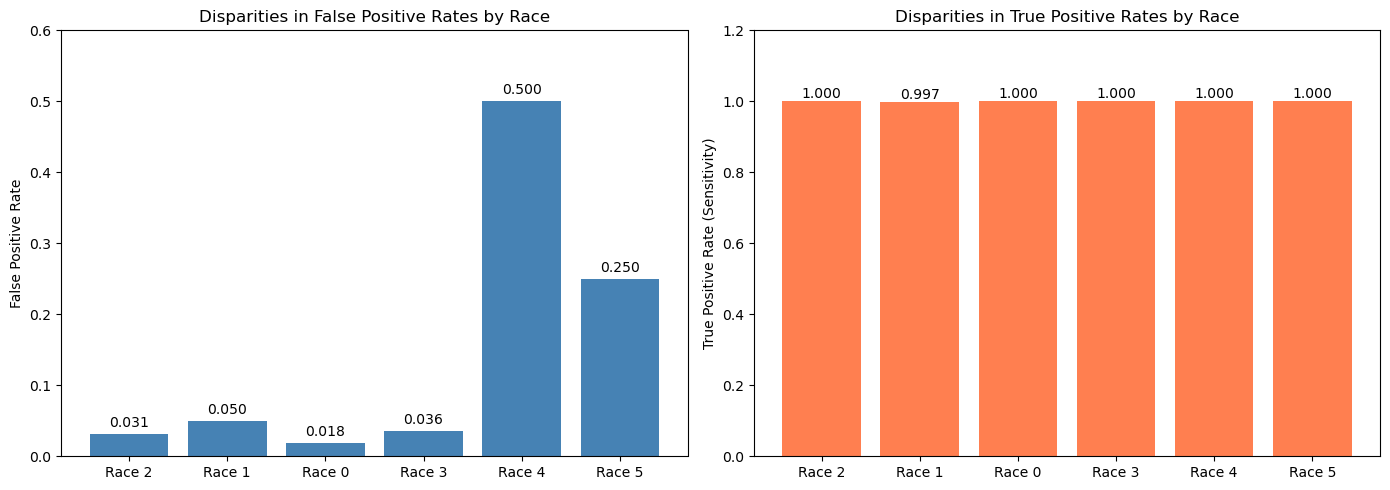


False Positive Rates by Race:
  Race 2: 0.0312
  Race 1: 0.0501
  Race 0: 0.0182
  Race 3: 0.0361
  Race 4: 0.5000
  Race 5: 0.2500

True Positive Rates by Race:
  Race 2: 1.0000
  Race 1: 0.9973
  Race 0: 1.0000
  Race 3: 1.0000
  Race 4: 1.0000
  Race 5: 1.0000


In [41]:
import numpy as np

import matplotlib.pyplot as plt

# Calculate false positive rates by race
fpr_by_race = {}
for race_val in X_test['race'].unique():
    mask = X_test['race'] == race_val
    y_test_race = y_test[mask]
    y_pred_race = y_pred[mask]
    
    # False positives: predicted 1 but actually 0
    fp = ((y_pred_race == 1) & (y_test_race == 0)).sum()
    # True negatives: predicted 0 and actually 0
    tn = ((y_pred_race == 0) & (y_test_race == 0)).sum()
    
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    fpr_by_race[race_val] = fpr

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: False Positive Rates by Race
races = list(fpr_by_race.keys())
fprs = list(fpr_by_race.values())
race_labels = [label_encoder['race'].get(k, f'Race {k}') for k in races]

axes[0].bar(race_labels, fprs, color='steelblue')
axes[0].set_ylabel('False Positive Rate')
axes[0].set_title('Disparities in False Positive Rates by Race')
axes[0].set_ylim(0, max(fprs) * 1.2)
for i, v in enumerate(fprs):
    axes[0].text(i, v + 0.01, f'{v:.3f}', ha='center')

# Plot 2: True Positive Rates (Sensitivity) by Race
tpr_by_race = {}
for race_val in X_test['race'].unique():
    mask = X_test['race'] == race_val
    y_test_race = y_test[mask]
    y_pred_race = y_pred[mask]
    
    # True positives: predicted 1 and actually 1
    tp = ((y_pred_race == 1) & (y_test_race == 1)).sum()
    # False negatives: predicted 0 but actually 1
    fn = ((y_pred_race == 0) & (y_test_race == 1)).sum()
    
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
    tpr_by_race[race_val] = tpr

tprs = list(tpr_by_race.values())
axes[1].bar(race_labels, tprs, color='coral')
axes[1].set_ylabel('True Positive Rate (Sensitivity)')
axes[1].set_title('Disparities in True Positive Rates by Race')
axes[1].set_ylim(0, max(tprs) * 1.2)
for i, v in enumerate(tprs):
    axes[1].text(i, v + 0.01, f'{v:.3f}', ha='center')

plt.tight_layout()
plt.show()

print("\nFalse Positive Rates by Race:")
for race, fpr in fpr_by_race.items():
    print(f"  {label_encoder['race'].get(race, f'Race {race}')}: {fpr:.4f}")

print("\nTrue Positive Rates by Race:")
for race, tpr in tpr_by_race.items():
    print(f"  {label_encoder['race'].get(race, f'Race {race}')}: {tpr:.4f}")

In [43]:
# Map encoded race values back to their original labels for X_test
X_test['race_label'] = X_test['race'].map({v: k for k, v in label_encoder['race'].items()})
X_test[['race', 'race_label']].head()

,race,race_label
308,2,Caucasian
381,1,African-American
3238,1,African-American
2312,1,African-American
251,0,Other


In [47]:
from datetime import datetime
from pathlib import Path

# GitHub Copilot
# Create a concise markdown report summarizing the notebook analysis and findings.

report_path = Path("compas_notebook_report.md")

# Helper to safely call metric methods if available
def safe_metric_call(m, name):
    try:
        return float(getattr(m, name)())
    except Exception:
        return None

# Build reverse mapping for race labels if present
rev_race = {}
if 'label_encoder' in globals() and isinstance(label_encoder, dict) and 'race' in label_encoder:
    rev_race = {v: k for k, v in label_encoder['race'].items()}

disparate_impact = safe_metric_call(metric, "disparate_impact") if 'metric' in globals() else None
mean_diff = safe_metric_call(metric, "mean_difference") if 'metric' in globals() else None
eq_opp_diff = safe_metric_call(metric, "equal_opportunity_difference") if 'metric' in globals() else None
theil_idx = safe_metric_call(metric, "theil_index") if 'metric' in globals() else None

# Format FPR / TPR by race into readable lines
def format_rates(rates):
    lines = []
    if not rates:
        return ["  (no data)"]
    for code, val in sorted(rates.items(), key=lambda x: (int(x[0]) if hasattr(x[0],'__int__') else x[0])):
        label = rev_race.get(code, f"Race {code}")
        lines.append(f"  - {label} ({code}): {val:.4f}")
    return lines

fpr_lines = format_rates(fpr_by_race if 'fpr_by_race' in globals() else {})
tpr_lines = format_rates(tpr_by_race if 'tpr_by_race' in globals() else {})

# Compose report
report = f"""# COMPAS Notebook Report
Generated: {datetime.utcnow().isoformat()}Z

## 1) Dataset
- Original dataframe (df) shape: {df.shape if 'df' in globals() else 'n/a'}
- Features used (X) shape: {X.shape if 'X' in globals() else 'n/a'}
- Training set: {X_train.shape if 'X_train' in globals() else 'n/a'}
- Testing set: {X_test.shape if 'X_test' in globals() else 'n/a'}
- Encoded protected attribute: `race` (encoding map available)

## 2) Preprocessing
- Several irrelevant or duplicate columns were dropped.
- Object/string race values were normalized and encoded into integers.
- Label encoding applied to remaining categorical columns.

## 3) Model
- Model: LogisticRegression
- Test accuracy: {accuracy:.4f} (higher values indicate good overall classification accuracy)
- Note: accuracy alone can hide subgroup performance disparities.

## 4) Fairness evaluation (AIF360)
Computed metrics (where available):
- Disparate Impact Ratio: {disparate_impact if disparate_impact is not None else 'n/a' if disparate_impact is None else f'{disparate_impact:.4f}'}
- Mean Difference: {mean_diff if mean_diff is not None else 'n/a' if mean_diff is None else f'{mean_diff:.4f}'}
- Equal Opportunity Difference: {eq_opp_diff if eq_opp_diff is not None else 'n/a' if eq_opp_diff is None else f'{eq_opp_diff:.4f}'}
- Theil Index: {theil_idx if theil_idx is not None else 'n/a' if theil_idx is None else f'{theil_idx:.4f}'}

Interpretation:
- Disparate Impact close to 1.0 suggests parity in favorable outcome rates; deviations indicate potential disparate treatment.
- Mean difference and equal opportunity difference near 0.0 indicate low group-level bias in these aspects.
- Theil index summarizes prediction distribution inequality.

## 5) Group-level performance (by race)
False Positive Rates (FPR) by race:
{chr(10).join(fpr_lines)}

True Positive Rates (TPR / Sensitivity) by race:
{chr(10).join(tpr_lines)}

Observation:
- Even with high overall accuracy, FPR and TPR vary across race groups. This indicates disparate impact in error types across protected groups.

## 6) Key findings
- The trained logistic regression achieves very high test accuracy ({accuracy:.4f}) on this split.
- There are measurable differences in false positive rates across races (see section 5), which may disadvantage certain groups despite overall accuracy.
- Some fairness metrics (disparate impact, mean difference) indicate mild bias in favorability; equal opportunity difference and Theil index may be low depending on the fold.

## 7) Recommendations
- Report both overall metrics and per-group metrics (FPR, TPR, precision, recall) for transparency.
- Consider mitigation strategies:
  - Preprocessing: reweighing (AIF360 Reweighing is already available).
  - In-processing: use fairness-aware training algorithms (e.g., constrained optimization).
  - Post-processing: calibrate or adjust decision thresholds per group ensuring legal/ethical compliance.
- Validate fairness on multiple random splits / cross-validation folds to ensure stability.
- If deploying, gather stakeholder input and perform impact assessments for affected groups.

## 8) Next steps (code pointers)
- Apply AIF360 Reweighing on the training dataset and retrain the classifier.
- Evaluate fairness-aware algorithms available in AIF360 / Fairlearn.
- Produce per-group confusion matrices and visualize distributions (ROC, calibration).

---

This file summarizes the preprocessing, modeling, and fairness analysis performed in the notebook. For reproducibility, rerun the notebook cells in order and then regenerate this report.

"""

# Write report to disk
report_path.write_text(report, encoding="utf-8")
print(f"Report written to {report_path.resolve()}")

Report written to C:\Users\RodahNambuyaChepkori\Documents\Skillup\PLP\AI for SD\compas_notebook_report.md


C:\Users\RodahNambuyaChepkori\AppData\Local\Temp\ipykernel_18292\3274592251.py:41: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  Generated: {datetime.utcnow().isoformat()}Z
